# Peter in volk: Realistično okolje

V naši situaciji se je Peter lahko premikal skoraj brez utrujenosti ali lakote. V bolj realističnem svetu se mora občasno usesti in spočiti, pa tudi nahraniti. Naredimo naš svet bolj realističen z uvedbo naslednjih pravil:

1. Z gibanjem iz enega kraja v drugega Peter izgublja **energijo** in pridobiva **utrujenost**.
2. Peter lahko pridobi več energije z uživanjem jabolk.
3. Peter se lahko znebi utrujenosti z počitkom pod drevesom ali na travi (tj. ko stopi na polje z drevesom ali travo - zeleno polje).
4. Peter mora najti in ubiti volka.
5. Da bi ubil volka, mora Peter imeti določene ravni energije in utrujenosti, sicer izgubi boj.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

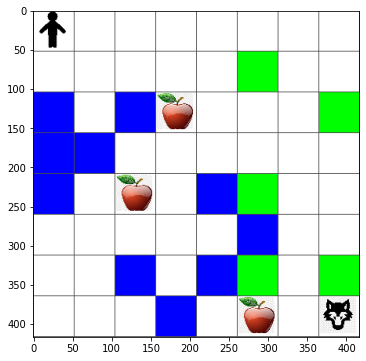

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Določanje stanja

V naših novih pravilih igre moramo spremljati energijo in utrujenost v vsakem stanju plošče. Zato bomo ustvarili objekt `state`, ki bo nosil vse potrebne informacije o trenutnem stanju problema, vključno s stanjem plošče, trenutnimi ravnmi energije in utrujenosti ter ali lahko premagamo volka v končnem stanju:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Poskusimo rešiti težavo z naključnim sprehodom in preverimo, ali nam uspe:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funkcija nagrajevanja

### Uvod
Funkcija nagrajevanja je ključni del sistema za kreiranje inteligentnih agentov. Omogoča agentu, da oceni svoje delovanje in se prilagodi za dosego optimalnih rezultatov.

### Cilji
- Definirati jasne kriterije za uspešnost.
- Spodbujati želeno vedenje.
- Preprečiti neželene stranske učinke.

### Struktura funkcije nagrajevanja
Funkcija nagrajevanja je običajno sestavljena iz več komponent, ki se združijo v eno samo vrednost. Te komponente lahko vključujejo:
- **Osnovne nagrade**: Nagrade za dosego osnovnih ciljev.
- **Kazni**: Kazni za neželena dejanja ali vedenje.
- **Bonusne nagrade**: Dodatne nagrade za preseganje pričakovanj.

### Primer
Spodaj je primer funkcije nagrajevanja:

```python
def reward_function(state, action):
    if state == "goal_reached":
        return 100  # Osnovna nagrada
    elif action == "undesired_action":
        return -10  # Kazen
    else:
        return 0  # Nevtralna vrednost
```

### Najboljše prakse
- **Jasnost**: Poskrbite, da je funkcija nagrajevanja enostavna za razumevanje in implementacijo.
- **Ravnovesje**: Zagotovite, da nagrade in kazni niso preveč ekstremne, saj lahko to vodi do nepredvidenega vedenja.
- **Testiranje**: Funkcijo nagrajevanja je treba temeljito testirati v različnih scenarijih.

### Pogoste napake
- **Preveč kompleksna funkcija**: Kompleksne funkcije nagrajevanja lahko otežijo učenje.
- **Nejasni cilji**: Če cilji niso jasno definirani, agent morda ne bo deloval optimalno.
- **Neupoštevanje stranskih učinkov**: Funkcija nagrajevanja mora upoštevati morebitne neželene posledice.

### Zaključek
Dobro zasnovana funkcija nagrajevanja je bistvenega pomena za uspeh inteligentnih agentov. Z upoštevanjem najboljših praks in izogibanjem pogostim napakam lahko ustvarite sistem, ki učinkovito dosega svoje cilje.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritem Q-Learning

Dejanski učni algoritem ostaja skoraj nespremenjen, le da namesto samo položaja na plošči uporabljamo `state`.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

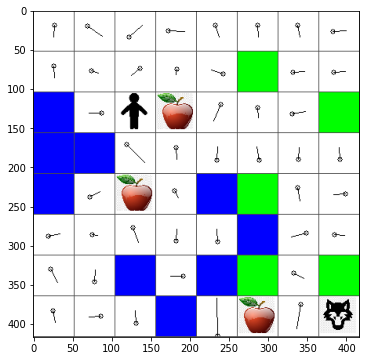

In [11]:
m.plot(Q)

## Rezultati

Poglejmo, ali smo bili uspešni pri treniranju Petra, da se bori proti volku!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Zdaj vidimo veliko manj primerov utopitve, vendar Peter še vedno ne more vedno ubiti volka. Poskusite eksperimentirati in preveriti, ali lahko izboljšate ta rezultat z igranjem s hiperparametri.


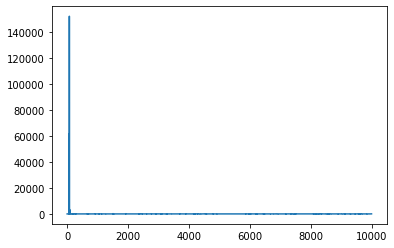

In [13]:
plt.plot(lpath)


---

**Omejitev odgovornosti**:  
Ta dokument je bil preveden z uporabo storitve za prevajanje z umetno inteligenco [Co-op Translator](https://github.com/Azure/co-op-translator). Čeprav si prizadevamo za natančnost, vas prosimo, da upoštevate, da lahko avtomatizirani prevodi vsebujejo napake ali netočnosti. Izvirni dokument v njegovem maternem jeziku je treba obravnavati kot avtoritativni vir. Za ključne informacije priporočamo profesionalni človeški prevod. Ne prevzemamo odgovornosti za morebitna napačna razumevanja ali napačne interpretacije, ki izhajajo iz uporabe tega prevoda.
